This notebook trains the model end-to-end.

- `Input to notebook` : the notebook anticipates artifacts generated after using `Notebooks/start.ipynb`. this name is confusing and must be changed asap.

- `Output` : Trained Models saved at : `data/saved_models`

In [1]:
## Start Feature Extraction from the collected Dataset

In [2]:
import os
import pandas as pd
import librosa
import librosa.display ## To deal with module `display` not found error

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
os.chdir('../')

import torch
import torchaudio
torch.cuda.is_available()

## This is necessary to find `src` folder
import sys
sys.path.append('C:\\Users\\Robin\\Downloads\\Podcast-Audio-Processing')

C:\Users\Robin\AppData\Local\Continuum\anaconda3\envs\audio\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\Robin\AppData\Local\Continuum\anaconda3\envs\audio\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


In [3]:
from src.settings import META_DATA_LOC

In [4]:
meta_data = pd.read_csv(META_DATA_LOC)

## if this doesn't hold .. some deep problem we gotta fix my myan
assert all(meta_data.start_time.isna() == meta_data.end_time.isna())

meta_data['label'] = ~meta_data.start_time.isna()
meta_data['label'] = meta_data['label'].astype(int) 

In [5]:
def get_melspectrogram_db(file_path, sr=8000, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

## Enter Torch Audio

TorchAudio is skipped for now because, it's basically doesn't work. Hope to say goodbye to windows soon

In [6]:
from IPython.display import Audio, display
test_tensor, test_sr = torchaudio.load('data/generated/0.wav')

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        return Audio(waveform[0], rate=sample_rate)
    elif num_channels == 2:
        return Audio((waveform[0], waveform[1]), rate=sample_rate)
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [7]:
## PLAY RAW AUDIO
play_audio( test_tensor, test_sr )

### Some Augmentations with torchaudio

In [8]:
# import random

# class RandomSpeedChange:
#     def __init__(self, sample_rate):
#         self.sample_rate = sample_rate

#     def __call__(self, audio_data):
#         speed_factor = random.choice([3, 4, 5])
#         if speed_factor == 1.0: # no change
#             return audio_data

#         # change speed and resample to original rate:
#         sox_effects = [
#             ["speed", str(speed_factor)],
#             ["rate", str(self.sample_rate)],
#         ]
#         transformed_audio, _ = torchaudio.sox_effects.apply_effects_tensor(
#             audio_data, self.sample_rate, sox_effects)
#         return transformed_audio

     
# speed_transformer = RandomSpeedChange(test_sr)
# transformed_audio = speed_transformer(test_tensor)

## Check the Traning Example Visually  

In [9]:
label_mapper = {
        'None' : 0,
        'start' : 1,
        'pause' : 2,
    }

meta_data['label'] = meta_data.label_type.map(label_mapper) 
meta_data.to_csv(META_DATA_LOC,index=False)

In [10]:
meta_data.sample(7)

,Unnamed: 0,Unnamed: 0.1,filename,start_time,end_time,label_type,label
106,106,106,106.wav,NaN,NaN,None,0
1979,1979,1979,1979.wav,1716.728551,2180.728551,pause,2
209,209,209,209.wav,3636.014565,4000.000000,start,1
2114,2114,2114,2114.wav,3969.024522,4000.000000,None,0
302,302,302,302.wav,3232.757363,3952.757363,start,1
2654,2654,2654,2654.wav,NaN,NaN,None,0
845,845,845,845.wav,3591.258348,4000.000000,pause,2


## Plot the Spectrograms

In [11]:
## by default sr value is : 22500
sample, _ = librosa.load('data/generated/1.wav')
sample_duration = librosa.get_duration( sample)

train_path = 'data/generated/'

## This will have a huge effect, 
display_sr = 16000

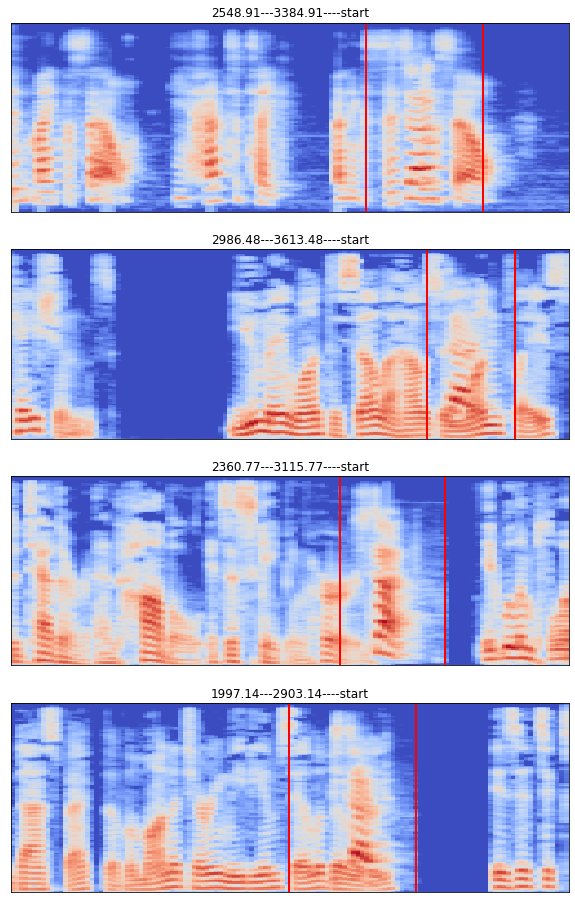

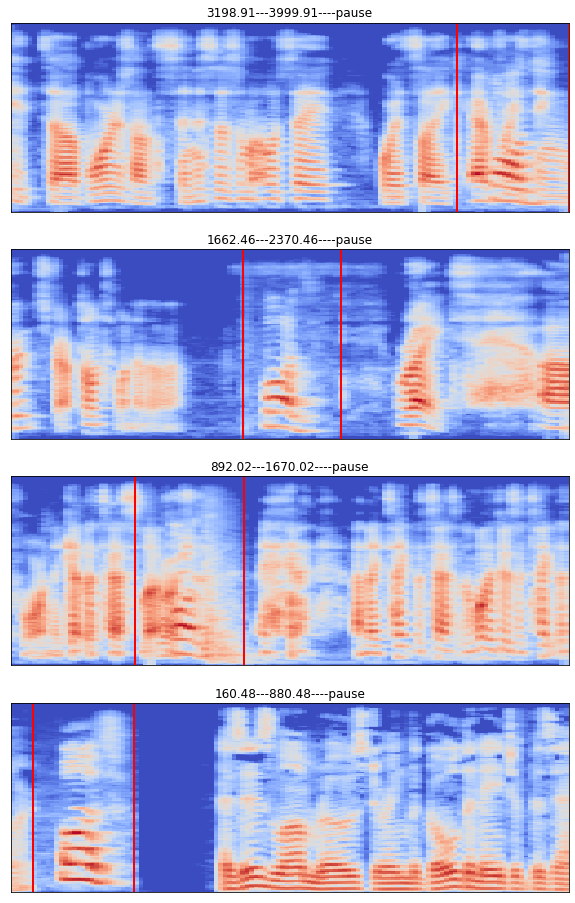

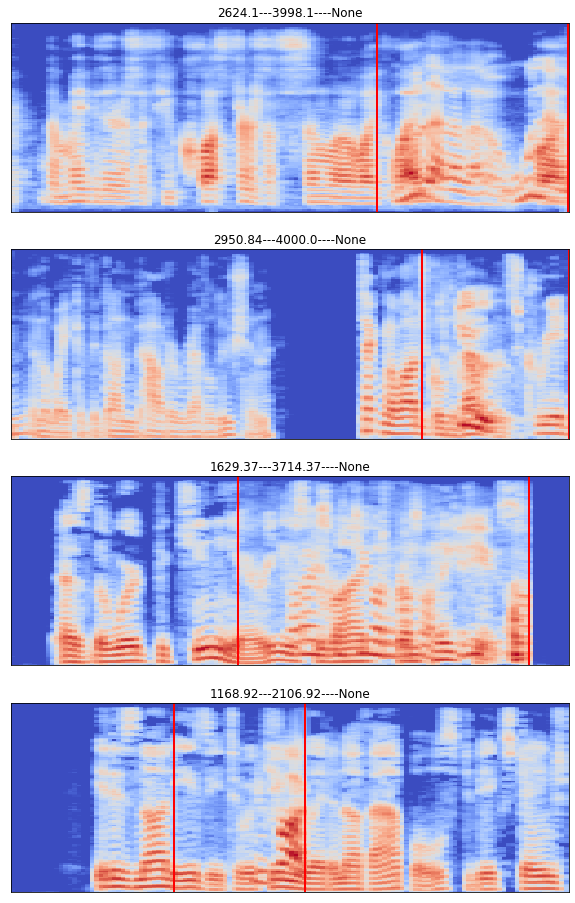

In [12]:
meta_data_train = meta_data[:1701]
meta_data_test = meta_data[1701:]

pos_examples = meta_data_train[meta_data_train.label == 1].sample(4)
neg_examples = meta_data_train[meta_data_train.label == 0].sample(4)
pause_examples = meta_data_train[meta_data_train.label == 2].sample(4)

mel_spec_pos = [ get_melspectrogram_db( os.path.join( train_path , pos_example.filename ) , display_sr  )  for _,pos_example in pos_examples.iterrows() ]

mel_spec_neg = [ get_melspectrogram_db( os.path.join( train_path , neg_example.filename ) , display_sr  ) for _,neg_example in neg_examples.iterrows() ]

mel_spec_pause = [ get_melspectrogram_db( os.path.join( train_path , pause_example.filename ) , display_sr  ) for _,pause_example in pause_examples.iterrows() ]


mel_scale_max = mel_spec_pos[0].shape[1]

def plot_samples(sample_df, spectrograms):
    ################################
    ###### IMPORTANT VARIABLE ######
    ################################

    ## We want this in Millisecond, becase that's how `start_time` and `end_time` is represented in `meta_data.csv`
    time_scale_max = sample_duration * 1000 

    potential_range_in_freq_domain = [  ( mel_scale_max * example.start_time / time_scale_max , 
                                          mel_scale_max * example.end_time / time_scale_max) 
                                          for _, example in sample_df.iterrows()]


    ### PLOT USING LIBROSA
    fig, ax = plt.subplots( len(sample_df) , 1, figsize=(10,16))
    for r in sample_df.reset_index().iterrows():
        row_ind = r[0]
        ax[row_ind].axvline( potential_range_in_freq_domain[ row_ind ][0], linewidth=2, color='red' )
        ax[row_ind].axvline( potential_range_in_freq_domain[ row_ind ][1], linewidth=2, color='red' )
        
        
        title_name = str(round(r[1].start_time,2)) + '---' + str(round(r[1].end_time,2)) + '----' + r[1].label_type
        ax[row_ind].set_title( 
            title_name
            )

        librosa.display.specshow(spectrograms[row_ind], ax=ax[row_ind] )    


plot_samples( pos_examples , mel_spec_pos )
plot_samples( pause_examples , mel_spec_pause )
plot_samples( neg_examples , mel_spec_neg )

### Check the Audio File

In [13]:
from pydub.playback import play
from pydub import AudioSegment

## Check one such example for Verification
pos_sound = AudioSegment.from_wav(os.path.join( train_path , pos_examples.iloc[0].filename ))
neg_sound = AudioSegment.from_wav(os.path.join( train_path , neg_examples.iloc[0].filename ))

def check_example(sound):

    ## playing positive example
    print('Playing ...')
    play( sound )
    print('Playing Stopped')

check_example(neg_sound)

Playing ...
Playing Stopped


## Apply Data Transformations

- Currently, I could not change towards using TorchAudio instead of Librosa. Because of some support issues with sox in Windows
- Speaking of windows, Windows is bad at supporting Multiprocessing with num_workers > 0. 
    - https://discuss.pytorch.org/t/dataloader-worker-failed/140518
    - Adding : Windows could not be more stupid. But I will fix it

In [14]:
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from src.settings import PROCESSED_DIR

### Define Some important Variables

In [15]:
BATCH_SIZE = 16
## other values give error
NUM_WORKERS = 0

## This is essential 
SAMPLE_RATE = 16000

In [16]:
class AudioLoader(Dataset):
    
    def __init__(self, transform=None, mode="train"):
        self.mode = mode
        self.audio_data_dir = PROCESSED_DIR
        meta_data = pd.read_csv(META_DATA_LOC)
        if self.mode == "train":
            self.meta_data = meta_data[:2001]
        elif self.mode == "test":
            self.meta_data = meta_data[2001:]
        else :
            self.meta_data = meta_data[:50]
        self.transform = transform

    def __len__(self):
        return self.meta_data.shape[0]

    def __getitem__(self, idx):
        filename = self.meta_data["filename"].iloc[idx]
        file_path = os.path.join(self.audio_data_dir, filename)

        data, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        data = self.transform(data)
        label = self.meta_data["label"].iloc[idx]

        return data, label

In [17]:
### BUILD CUSTOM AUGMENTATION FUNCTION ###
from audiomentations import (AddGaussianNoise, Compose, PitchShift, Shift,
                             SpecFrequencyMask, TimeMask, TimeStretch)


## We randomly Apply these transformations below, in training data
waveform_augment = Compose(
    [
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.1),
        # Fills to Minimum value of waveform
        TimeMask(min_band_part=0.1, max_band_part=0.15, fade=False, p=0.2),
        TimeStretch(min_rate=0.7, max_rate=1.25, p=0.3),
#         PitchShift(min_semitones=-4, max_semitones=4, p=1),
        Shift(min_fraction=-0.5, max_fraction=0.5, p=0.3),
    ]
)


## by default, librosa loads at sr value : 22500 
sample, sample_rate = librosa.load('data/generated/0.wav', sr = 44100)
sample_duration = librosa.get_duration( sample , sr=44100)


print("Before Augmentation")
# waveform_augment(sample, SAMPLE_RATE)
Audio(sample, rate=sample_rate)

Before Augmentation


In [18]:
print("After Augmentation")
Audio( waveform_augment(sample,sample_rate=sample_rate), rate=sample_rate )

After Augmentation


In [19]:
#############################################################
### converted from lambda functions due to problem in Windows
#############################################################

# training_transformation = transforms.Compose(
#     [
#         lambda x: waveform_augment(x, SAMPLE_RATE),
#         lambda x: librosa.feature.melspectrogram(
#             x, sr=SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300
#         ),
#         lambda x: librosa.power_to_db(x, top_db=80),
# #         lambda x: (x - norm_dict["global_mean"]) / norm_dict["global_std"],
# #         lambda x: CustomFreqMask(fill_val=x.min())(x),
#         lambda x: x.reshape(1, x.shape[0], x.shape[1])
#     ]
# )


def training_transformation(x):
    x = waveform_augment(x, SAMPLE_RATE)
    x = librosa.feature.melspectrogram(
            x, sr=SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300
        )
    x = librosa.power_to_db(x, top_db=80)
    x = x.reshape(1, x.shape[0], x.shape[1])
    return x

trainloader = DataLoader(
    AudioLoader(transform=training_transformation, mode="train"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)


#################################################################
### converted from lambda functions due to problem in Windows ###
#################################################################

# validation_transformation = transforms.Compose(
#     [
#         lambda x: librosa.feature.melspectrogram(
#             x, sr=SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300
#         ),
#         lambda x: librosa.power_to_db(x, top_db=80),
# #         lambda x: (x - norm_dict["global_mean"]) / norm_dict["global_std"],
#         lambda x: x.reshape(1, x.shape[0], x.shape[1]),
#     ]
# )

def validation_transformation(x):
    x = librosa.feature.melspectrogram(
            x, sr=SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300
        )
    x = librosa.power_to_db(x, top_db=80)
    x = x.reshape(1, x.shape[0], x.shape[1])
    return x

testloader = DataLoader(
    AudioLoader(transform=validation_transformation, mode="test"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    )

## This is useful to check training on a small subset of data before goining big.
train_small_loader = DataLoader(
    AudioLoader(transform=training_transformation, mode="train_small"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    )

## Model Building

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [29]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()

# #         self.drp = nn.Dropout2d(0.2)
# #         self.fc_drp = nn.Dropout(0.2)
#         self.pool1 = nn.MaxPool2d(2, stride=1)
#         self.pool2 = nn.MaxPool2d(2, stride=2)
#         self.pool3 = nn.MaxPool2d(2, stride=3)

#         self.conv1 = nn.Conv2d(1, 24, 5, dilation=1, stride=1) 
#         self.conv1_bn = nn.BatchNorm2d(24)

#         self.conv2 = nn.Conv2d(24, 32, 7, dilation=1, stride=1)
#         self.conv2_bn = nn.BatchNorm2d(32)

#         self.conv3 = nn.Conv2d(32, 64, 9, dilation=1, stride=2)
#         self.conv3_bn = nn.BatchNorm2d(64)

# #         self.conv4 = nn.Conv2d(64, 64, 11, dilation=1, stride=2)
# #         self.conv4_bn = nn.BatchNorm2d(64)

#         self.fc1 = nn.Linear(64 * 27 * 26 , 64)
#         self.fc2 = nn.Linear(64, 3)

#     def forward(self, x):
# #         print(x.shape)
#         x = self.conv1_bn(self.pool1(F.relu(self.conv1(x))) )
# #         print(x.shape)
#         x = F.dropout(x, p=0.3, training=self.training )

#         x = self.conv2_bn(self.pool1(F.relu(self.conv2(x))) )
#         x = F.dropout(x, p=0.3, training=self.training )
        
# #         x = self.drp(x)

#         x = self.conv3_bn(self.pool2(F.relu(self.conv3(x))) )
#         x = F.dropout(x, p=0.3, training=self.training )
# #         x = self.drp(x)

# #         x = self.conv4_bn(self.pool3(F.relu(self.conv4(x))))
# #         x = self.drp(x)
# #         import pdb; pdb.set_trace()
#         x = x.view(-1, 64 * 27 * 26)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, p=0., training=self.training )

#         x = self.fc2(x)

#         return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

#         self.drp = nn.Dropout2d(0.2)
#         self.fc_drp = nn.Dropout(0.2)
        self.pool1 = nn.MaxPool2d(2, stride=1)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.pool3 = nn.MaxPool2d(2, stride=3)

        self.conv1 = nn.Conv2d(
            1, 24, 5, dilation=1, stride=1
        )  # inchannel , outchannel , kernel size ..
        self.conv1_bn = nn.BatchNorm2d(24)

        self.conv2 = nn.Conv2d(24, 32, 7, dilation=1, stride=1)
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 9, dilation=1, stride=2)
        self.conv3_bn = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, 11, dilation=1, stride=2)
        self.conv4_bn = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1_bn(self.pool1(F.relu(self.conv1(x))))
#         x = self.drp(x)
        x = F.dropout(x, p = 0.2, training=self.training)
    
        x = self.conv2_bn(self.pool1(F.relu(self.conv2(x))))
#         x = self.drp(x)
        x = F.dropout(x, p = 0.2, training=self.training)

        x = self.conv3_bn(self.pool2(F.relu(self.conv3(x))))
#         x = self.drp(x)
        x = F.dropout(x, p = 0.2, training=self.training)

        x = self.conv4_bn(self.pool3(F.relu(self.conv4(x))))
#         x = self.drp(x)
        x = F.dropout(x, p = 0.2, training=self.training)

        # import pdb ; pdb.set_trace()
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
#         x = self.fc_drp(x)
        x = F.dropout(x, p = 0.2, training=self.training)

        x = self.fc2(x)

        return x


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print( "USING : " , device)

# defining the model
model = Net()
model.cuda()
# defining the optimizer
optimizer = torch.optim.Adam(model.parameters())
# defining the loss function
criterion = nn.CrossEntropyLoss ().to(device)
print(model)

USING :  cuda:0
Net(
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(24, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(9, 9), stride=(2, 2))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(11, 11), stride=(2, 2))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_fea

In [31]:
model_type = ''

In [32]:
## Initailize model with existing weights if present
from src.settings import MODEL_DATA_LOC
MODEL_DATA_LOC.mkdir(parents=True, exist_ok=True)

if os.listdir(MODEL_DATA_LOC):
    print('Initializing Model and optimizer with last values .. ')
    model_save_name = sorted(os.listdir(MODEL_DATA_LOC))[-1]
    state = torch.load( MODEL_DATA_LOC / model_save_name )
    
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    prev_validation_loss = state['validation_loss']
    prev_validation_accuracy = state['validation_accuracy']
    last_epoch = state['epoch']
    print(f'Last Val Loss : {prev_validation_loss} , Last Val Acc : {prev_validation_accuracy} , Last Epoch : {last_epoch}')
else :
    print('Training from scratch')
    prev_validation_loss = np.inf
    last_epoch = 0

Initializing Model and optimizer with last values .. 
Last Val Loss : 24.754349775612354 , Last Val Acc : 0.3483560090702948 , Last Epoch : 15


## Training the model

### First do a Overfitting Run

Decrease Trend of Loss in a small Sample ensures that Model indeed has a Capacity to Learn

In [33]:
# def calc_accuracy(outputs, labels):
#     total_examples = len(outputs)
#     correct_pred = torch.sum((outputs >= 0.5) == labels).to("cpu").item()
#     return correct_pred / total_examples

In [34]:
# for epoch in range(40):  # loop over the dataset multiple times

#     model.train()
#     running_loss = 0.0
#     training_acc = []
#     for i, data in enumerate(train_small_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)
# #         inputs, labels = data[0].cuda(), data[1].cuda()
# #         labels = labels.unsqueeze(1)
#         # zero the parameter gradients
#         optimizer.zero_grad()
#         # forward + backward + optimize
#         outputs = model(inputs)
#         labels = labels.type(torch.long)

#         loss = criterion(outputs, labels)

#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         training_acc.append( np.mean((torch.argmax(outputs,axis=1) == labels).cpu().numpy()) )

# #         if i %  10 == 0 :    #
#     avg_training_acc = sum(training_acc)/len(training_acc)
#     print( f'Upto {epoch+1}th Epoch :  Loss accumulated upto : {running_loss} || Running Train Accuracy : {avg_training_acc}' )

## DO REAL TRAINING HERE

In [35]:
import time
from sklearn.metrics import confusion_matrix

In [ ]:
for epoch in range(last_epoch + 1, last_epoch + 15):  # loop over the dataset multiple times
    
    ### Training Part ###
    train_start_time = time.time()
    
    model.train()
    curr_training_loss = 0.0
    training_acc = []
    
    time_to_backprop = 0
    
    for i, data in enumerate(trainloader, 0):
        
        propagation_start = time.time()
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        labels = labels.type(torch.long)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        propagation_end = time.time()
        time_to_backprop += round(propagation_end - propagation_start  , 2 )
        
        # print statistics
        curr_training_loss += loss.item()
        
        train_preds = torch.argmax(F.softmax(outputs , dim=1), axis=1)
        training_acc_per_iter = np.mean( (train_preds == labels).cpu().numpy() )
        training_acc.append( training_acc_per_iter )
        
        
        if i % 10 == 0:
            print(f'At Epoch : {epoch} -- iteration : {i} -- Training Loss :  {loss.item()} -- Training Acc : {training_acc_per_iter}')
            ## FOR DEBUGGING ONLY ##
#             break
            
    train_end_time = time.time()

    ### Evaluation Part ###
    model.eval()
    curr_val_loss = 0.0
    val_acc = []
    
    actual_labels = []
    predicted_labels = []
    
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        labels = labels.type(torch.long)
        loss_val = criterion(outputs, labels)

        curr_val_loss += loss_val.item()
        val_preds = torch.argmax(F.softmax(outputs , dim=1), axis=1)
        val_acc_per_iter = np.mean( (val_preds == labels).cpu().numpy() )
        
        actual_labels.extend( labels.cpu().tolist() )
        predicted_labels.extend( val_preds.cpu().tolist() )
        val_acc.append(val_acc_per_iter)
        
        ## FOR DEGUGGING ONLY
#         if i % 10 == 0:
#             break
        

    combined_training_acc = sum(training_acc)/len(training_acc)
    combined_val_acc = sum(val_acc)/len(val_acc)
    training_time_for_epoch =  round( train_end_time - train_start_time , 3 )
    
    ######### PRINT THE CONFUSION MATRIX ##########
    confusion_mat  = confusion_matrix( actual_labels, predicted_labels )
    print(f'Validation Set Confusion Matrix : \n {confusion_mat}\n')
    
    ######### PRINT OTHER METRICS ########
    if curr_val_loss < prev_validation_loss: 
        print('Saving Model ..')   
        print(f'After Epoch {epoch + 1} : Training Loss {curr_training_loss} || Validation loss {curr_val_loss}')
        print(f'Training Accuracy : {combined_training_acc} || Validation Accuracy : {combined_val_acc}')
        print(f'Total Time Taken For Epoch : {training_time_for_epoch} seconds')
        print(f'Total Time consumed by backprop part  : {time_to_backprop} seconds')
        

        
        state = {
            'epoch': epoch + 1, 
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(), 
            'validation_loss': curr_val_loss,
            'validation_accuracy' : combined_val_acc }
        filename = MODEL_DATA_LOC / f'model__sr_{SAMPLE_RATE}__epoch_{epoch+1}'
        torch.save(state, filename)

At Epoch : 16 -- iteration : 0 -- Training Loss :  0.39757251739501953 -- Training Acc : 0.875
At Epoch : 16 -- iteration : 10 -- Training Loss :  0.38095995783805847 -- Training Acc : 0.875
At Epoch : 16 -- iteration : 20 -- Training Loss :  0.15983125567436218 -- Training Acc : 0.9375
At Epoch : 16 -- iteration : 30 -- Training Loss :  0.23278944194316864 -- Training Acc : 0.9375
At Epoch : 16 -- iteration : 40 -- Training Loss :  0.289071261882782 -- Training Acc : 0.875
At Epoch : 16 -- iteration : 50 -- Training Loss :  0.25000283122062683 -- Training Acc : 0.9375
At Epoch : 16 -- iteration : 60 -- Training Loss :  0.3536086976528168 -- Training Acc : 0.8125
At Epoch : 16 -- iteration : 70 -- Training Loss :  0.20214053988456726 -- Training Acc : 0.9375
At Epoch : 16 -- iteration : 80 -- Training Loss :  0.23955334722995758 -- Training Acc : 0.9375
At Epoch : 16 -- iteration : 90 -- Training Loss :  0.20059825479984283 -- Training Acc : 0.9375
At Epoch : 16 -- iteration : 100 -- T